<a href="https://colab.research.google.com/github/dnb0512/Coursera_Capstone/blob/master/Notebookdepresentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to project Data
The following notebook is an attempt to resume our procedure validation model, we hope you enjoy it.
please feel free to contact us at dnb0512@gmail.com 

## Our Hypothesis.

We intend to build a deep learning model that allows us to calculate how likely is a failure to happen over a fixed period of time. There's no point in discussing if this can be possible or not as it will be a discussion of how much computational power it needed to get there, so the need for easy and fast models must be added to the problem solution.

We know our approach is not that easy to see, and at its most is a leap of faith. Don't worry; we had doubts too, that's why we build an "easy" model to get a glimpse of our final product. That model is what we intend to show in detail during this notebook.

There's also the elephant in the room that we will be discussing little in this notebook. But make no mistake that we're mindful of it and work is being done to release our solution soon. An IoT device that allows us to read current and pressure sensors, filter data, and communicate with the server is needed so everything can work.

# Sección nueva

### What did we do?
Our approach to the problem is based on two premises:
- Anomaly patterns are detectable using duty point tracking.
- Pump/system indicators can improve model performance and predictive capabilities. 

A simple experiment was designed to get a hold if this could work. Like most of you, readers, know close valve operation is a critical operation point for any pump; it also is easy to accomplish using a gate valve. With this in mind, a test bench using 3 Pedrollo CPM-600  0.5 HP 1Ph 115V was built where 82 operations to event cycles were forced to happen. 

In [ ]:
import matplotlib
%matplotlib inline
matplotlib.use
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Let's have a look at the training data collected from the pumps and how it was processed.
Data from ACS712 current sensor along with Danfos MBS1900 pressure transducers (To convert the 4-20mA signal to 0-5VDC XY-IY0V module was used.) was collected using an Arduino Mega board.

Data processed  was done using python and taking into account the following assumptions:
- Our system registered an average of 5 data points per second.
- Timestamps were irrelevant as we could say that a data point was a day, month, etc. But to reduce computational power median filter was used on 300 samples.

In [ ]:
close_valve=pd.read_csv('Final.csv')
close_valve.drop(['Unnamed: 0','status','Voltaje1'],axis=1,inplace=True)
close_valve.head()

,Amperaje1,Presion1,ciclo,tiempo
0,5.07,1.33,0,0
1,5.11,1.34,0,1
2,5.07,1.30,0,2
3,5.05,1.33,0,3
4,5.03,1.41,0,4


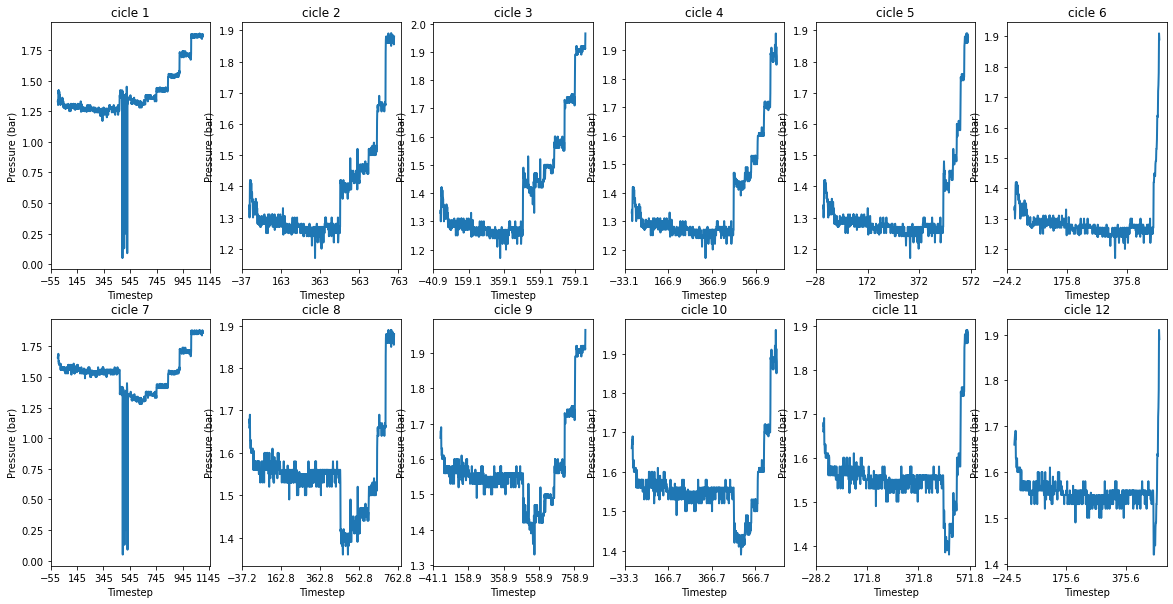

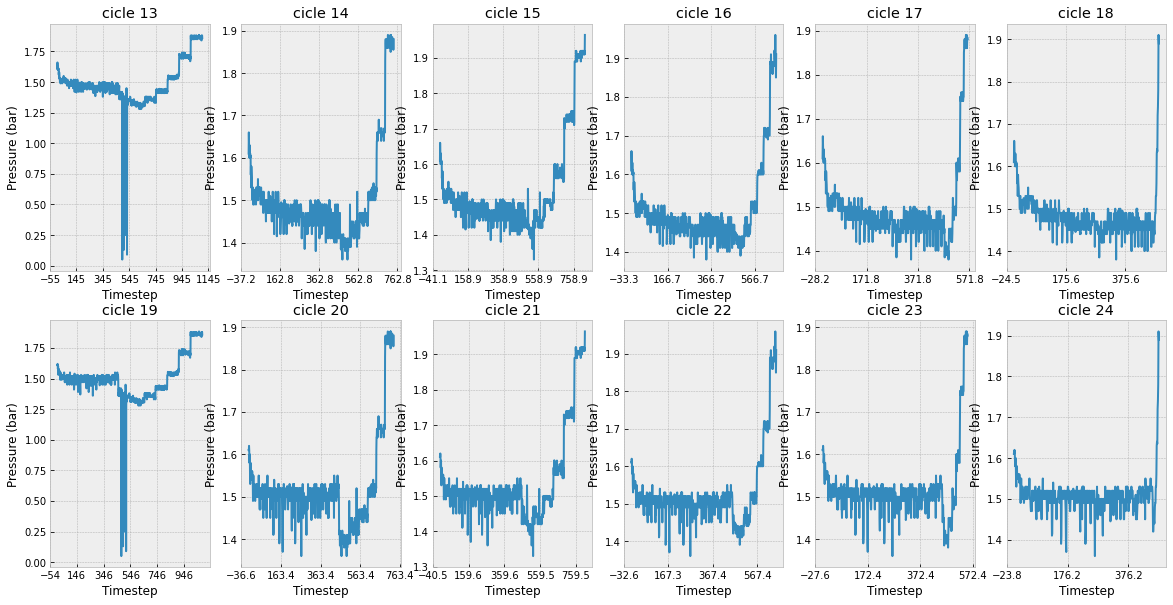

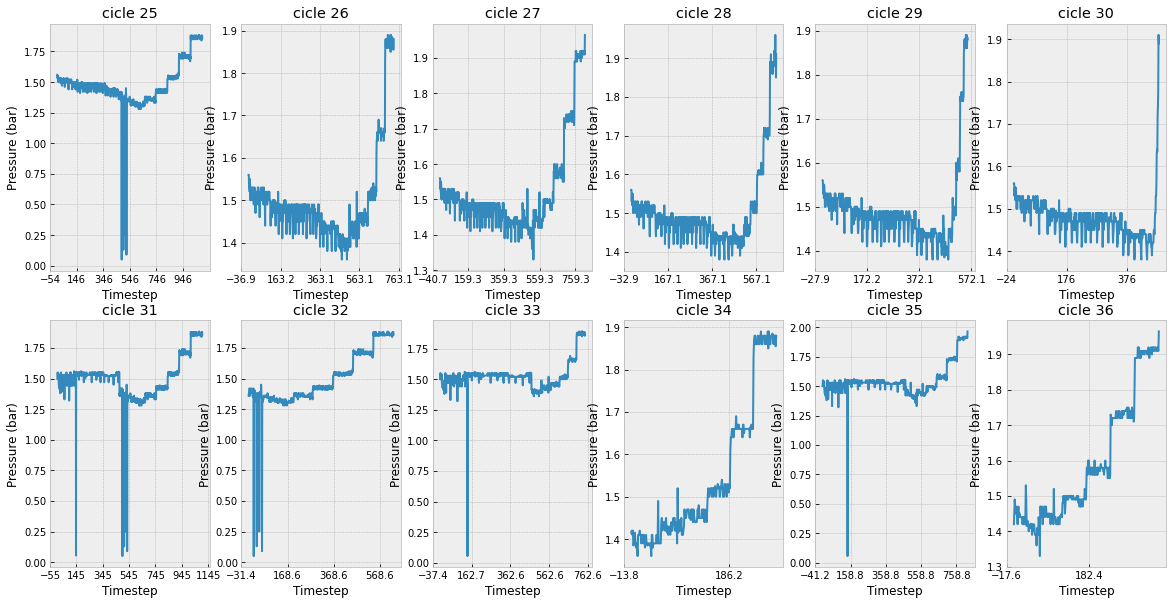

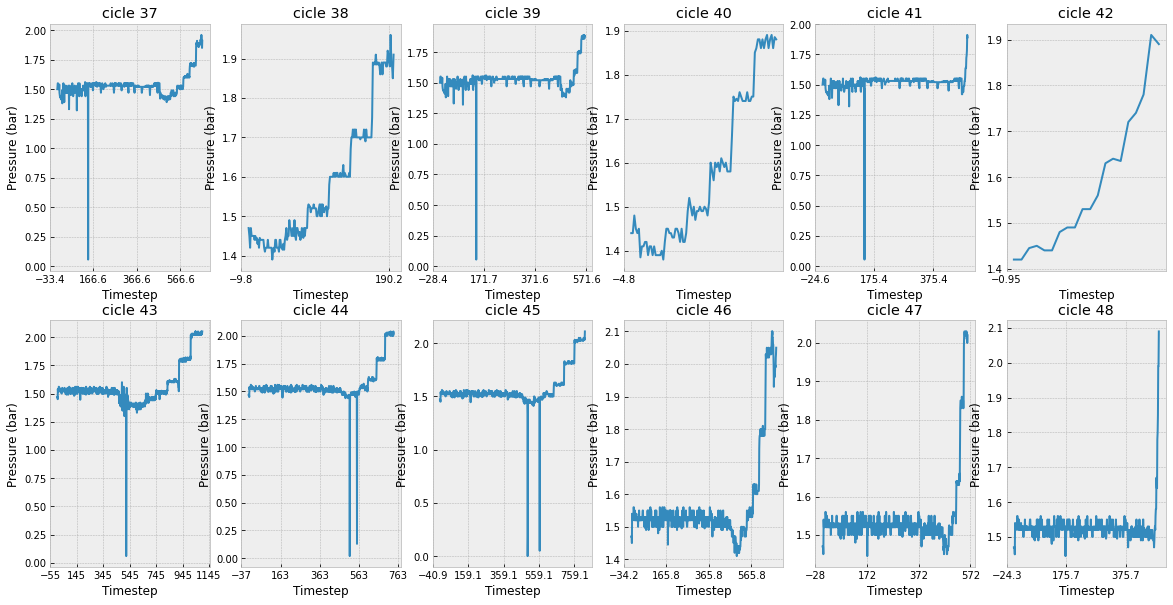

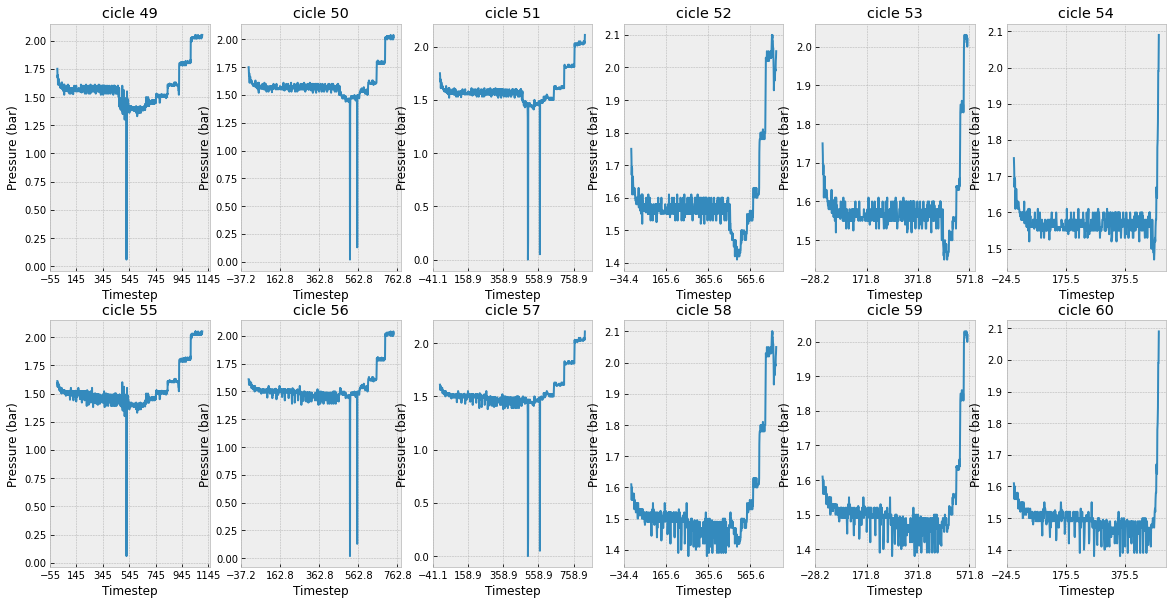

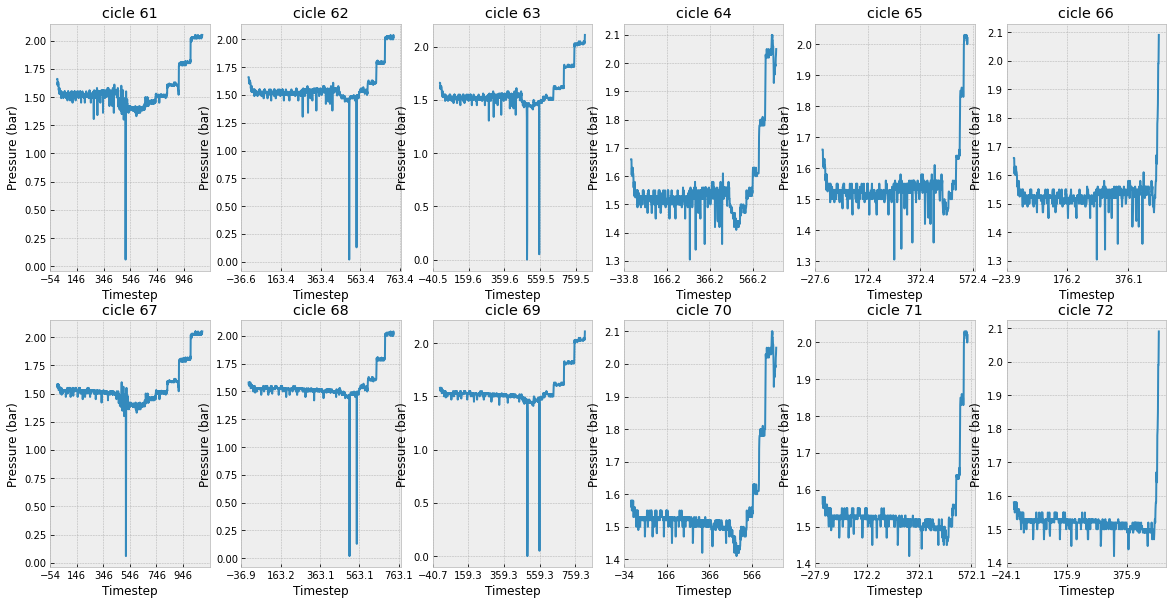

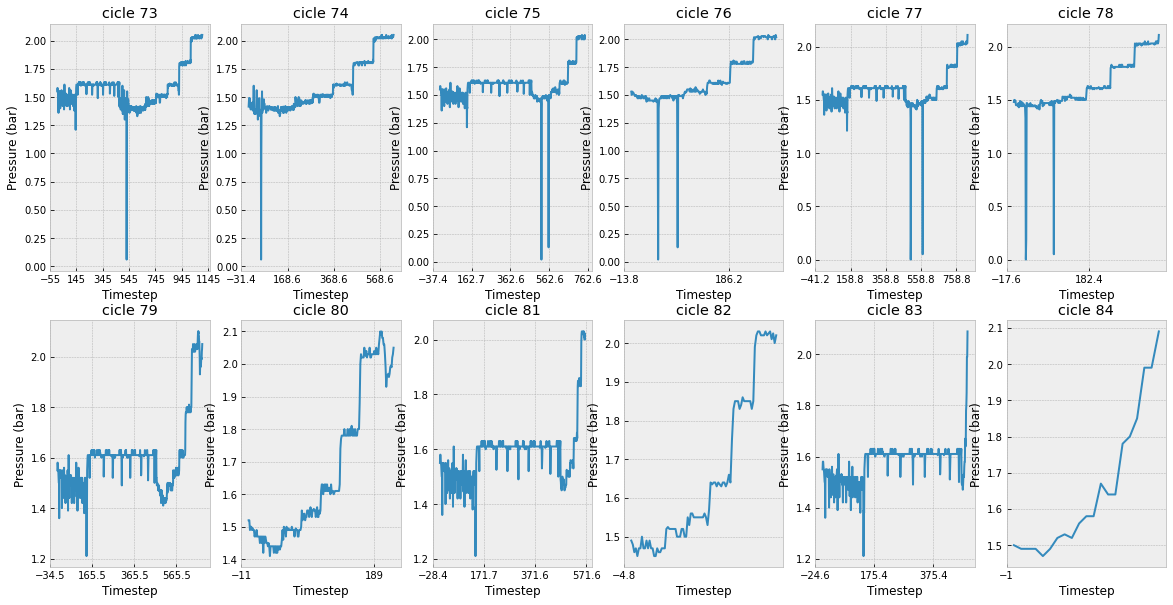

In [ ]:
figure=1
while figure<84:
  fig, ax1= plt.subplots(nrows=2,ncols=6,figsize=(20,10))
  plt.style.use('bmh')
  ind=figure-1
  for j in ax1:
    for i in j:
      i.plot(close_valve.loc[close_valve['ciclo']==ind]['tiempo'],close_valve.loc[close_valve['ciclo']==ind]['Presion1'])
      i.title.set_text(f'cicle {ind}')
      i.set_ylabel('Pressure (bar)')
      i.set_xlabel('Timestep')
      start,end=[0,0]
      start, end = i.get_xlim()
      i.xaxis.set_ticks(np.arange(start, end, 200))
      ind+=1
      i.title.set_text(f'cicle {ind}')
  figure+=12

The data has a lot of noise and a really bumpy behavior; Arduino code did not include any handling for this as we intend to make IoT as cheap and accessible as possible. Also, the model would benefit a lot from this approach as noise sometimes help prevent overfitting. This for us as we're using such generalization ( 1 pump model training data used to predict all pumps behavior**).

** Centrifugal pumps as the dynamics don't vary that much using a broad approach.

### Did it work?
We believe so; Our model was used to predict how many timesteps were left until maximum pressure was reached on 5 randomly selected pumps and 6 different operating pressure cycles. 

In [ ]:
model_results_full=pd.read_csv('Model_results_full.csv').transpose()
model_results_partial=pd.read_csv('Model_results_partial.csv').transpose()
pump_performance=pd.read_csv('Pump_perfomance.csv')
graphs=pd.DataFrame()
partial=[]
for j in pump_performance['ciclo'].unique():
  predictions_full= np.array(model_results_full[j][~np.isnan(model_results_full[j])])[1:]
  predictions_partial= np.array(model_results_partial[j][~np.isnan(model_results_partial[j])])[1:]
  final=pump_performance.loc[pump_performance['ciclo']==j]
  final['time_full']=predictions_full
  partial.append(predictions_partial)
  graphs=graphs.append(final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

The following lines of code will graph our conclusions while addressing each objective individually.

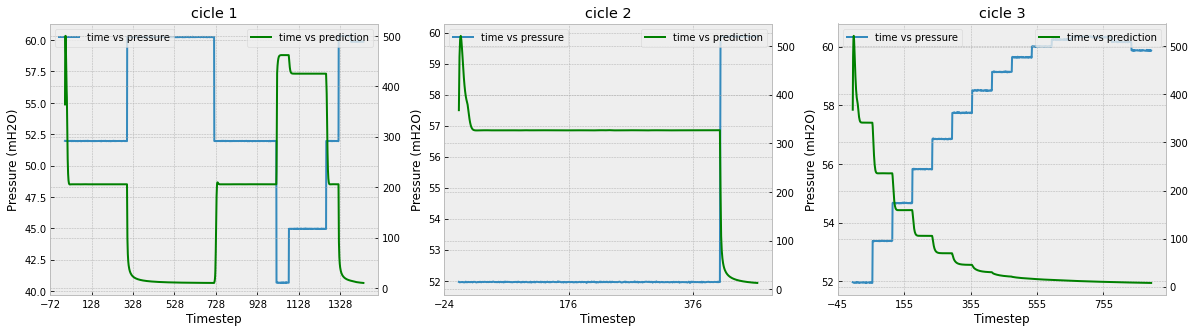

In [ ]:
fig, ax1= plt.subplots(nrows=1,ncols=3,figsize=(20,5))
plt.style.use('bmh')
ind=0
for i in ax1:
  i.plot(graphs.loc[graphs['ciclo']==ind]['tiempo'],graphs.loc[graphs['ciclo']==ind]['presion'])
  ax2=i.twinx()
  ax2.plot(graphs.loc[graphs['ciclo']==ind]['tiempo'],graphs.loc[graphs['ciclo']==ind]['time_full'],c='g')
  i.title.set_text(f'cicle {ind}')
  i.set_ylabel('Pressure (mH2O)')
  i.set_xlabel('Timestep')
  start,end=[0,0]
  start, end = i.get_xlim()
  i.xaxis.set_ticks(np.arange(start, end, 200))
  ind+=1
  i.title.set_text(f'cicle {ind}')
  i.legend(['time vs pressure'],loc='upper left')
  ax2.legend(['time vs prediction'],loc='upper right')

Pumps dutty point are relatively easy to track for any human; a plot of the curve and the operating pressure in a given moment is enough information for us.  A computer program can also perform the same with a bit more information, so why the above graphs are considered a milestone? To answer that, an understanding of the information anyone gets from a pump curve needs to happen, so let's make a quick summary:

- Dutty point location is a consequence of the system dynamics; therefore, any change will reflect a movement on it.
- Euclidean, Manhattan, or any other distance measurements are practical for unique case analysis, but you need more advanced tools for generalization; hence the probability of a given specific type of pump comes into play.

In summary, the graph above shows our model prediction (in timesteps remaining) to each dutty point on three different systems dynamics, where each calculation only uses the information obtained before it. The power of that conclusion is that our system can track duty points from a reference in a more generalized picture. Regardless of the pump model, it can identify the dutty point behavior on the system dynamics.

The following three graphs display the PDF in differents timesteps.

Text(0, 0.5, 'Pressure(mH2o)')

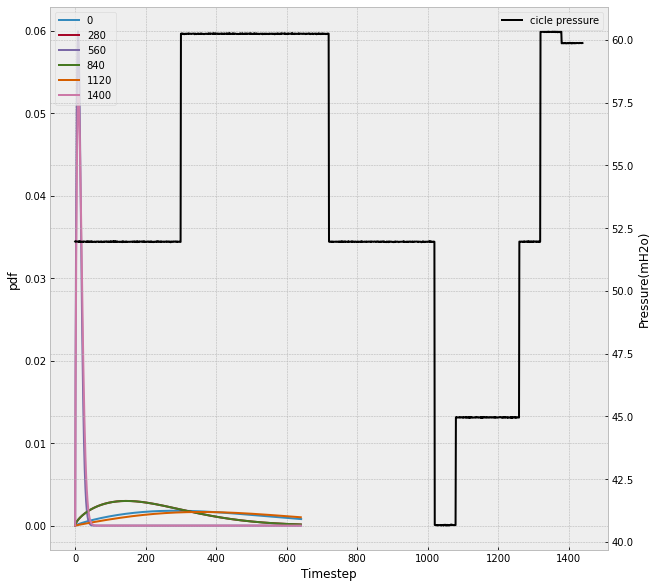

In [ ]:
zero_pdf=pd.read_csv('casezero-pdf.csv')
plt.style.use('bmh')
plt.figure(figsize=(10,10))
t=np.arange(0,1440)
ind=list(range(0,1440,280))
for i in ind:
  plt.plot(zero_pdf[f'{i}'])
plt.legend(ind,loc='upper left')
plt.ylabel('pdf')
plt.xlabel('Timestep')
ax2=plt.twinx()
ax2.plot(graphs.loc[graphs['ciclo']==0]['presion'],c='k')
ax2.legend(['cicle pressure'],loc=('upper right'))
ax2.set_ylabel('Pressure(mH2o)')

We would like to take a small pause and to thank you for reading this far;  it´ll mean a lot for us to receive your comments so, feel free to write us at dnb0512@gmail.com.


As a recap, we have already established the following points:
- Using a single 1/2 HP pump on different system dynamics, we manage to generate a generalized model. This one was able to work on five separate pumps profiles models and six completely different systems dynamics accurately predicting when a curve event occurred.
- Statistics allowed keeping track of an event more accurately to improve accuracy when a generalized model. The pdf graph shows how our model increase o decrease its likelihood based on the pressure and how close we´re to the intended dutty point.

But did our indicators help our model become more accurate?  A second model helps us answer that; it uses the same hyperparameters but only receives pressure and current data for each timestep. Here are the same graphs we review above using it.

In [ ]:
model2_results_full=pd.read_csv('Model2_results_full.csv').transpose()
pump_performance=pd.read_csv('Pump_perfomance.csv')
graphs2=pd.DataFrame()
for j in pump_performance['ciclo'].unique():
  predictions2_full= np.array(model2_results_full[j][~np.isnan(model2_results_full[j])])[1:]
  final=pump_performance.loc[pump_performance['ciclo']==j]
  final['time_full2']=predictions2_full
  graphs2=graphs2.append(final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

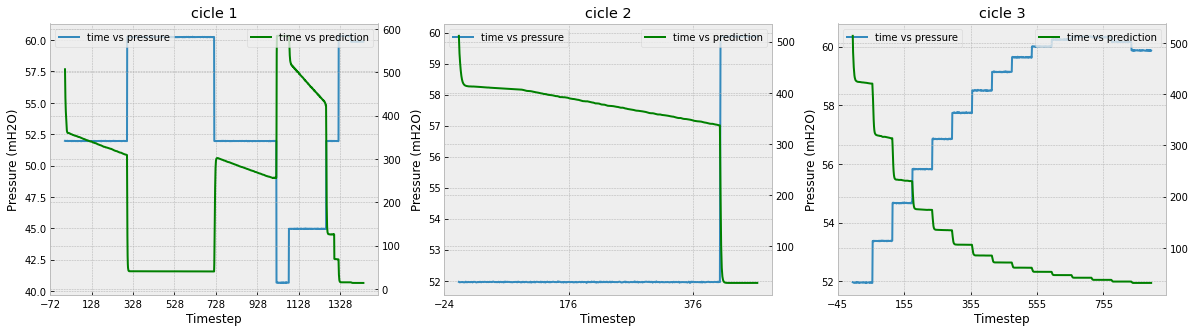

In [ ]:
fig, ax1= plt.subplots(nrows=1,ncols=3,figsize=(20,5))
plt.style.use('bmh')
ind=0
for i in ax1:
  i.plot(graphs2.loc[graphs2['ciclo']==ind]['tiempo'],graphs2.loc[graphs2['ciclo']==ind]['presion'])
  ax2=i.twinx()
  ax2.plot(graphs2.loc[graphs2['ciclo']==ind]['tiempo'],graphs2.loc[graphs2['ciclo']==ind]['time_full2'],c='g')
  i.title.set_text(f'cicle {ind}')
  i.set_ylabel('Pressure (mH2O)')
  i.set_xlabel('Timestep')
  start,end=[0,0]
  start, end = i.get_xlim()
  i.xaxis.set_ticks(np.arange(start, end, 200))
  ind+=1
  i.title.set_text(f'cicle {ind}')
  i.legend(['time vs pressure'],loc='upper left')
  ax2.legend(['time vs prediction'],loc='upper right')

The graphs show Sutil but different behaviors when both models predicted each timestep. The first one shows a more suitable pattern when constant pressure appears on the system dynamics, maintaining a more stable likelihood over time. Another interesting difference lies in the influence time has on the second one; it tends to drop based on a linear pattern which, is a nondesire condition for our failure review hypothesis. 

Now let's check how each model behaves. We calculated the error for each of the 30 validation samples on the last timestep. Here are the distribution plots for each of the models. 


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2056

Text(0.5, 1.0, 'Model without indicators')

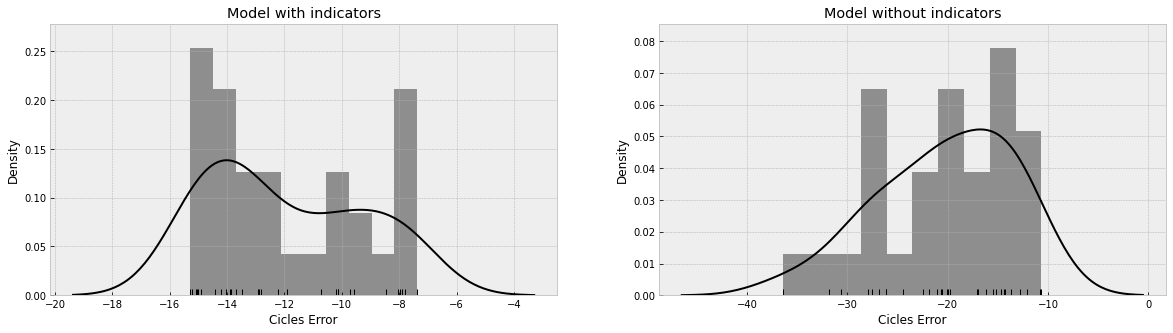

In [ ]:
fig, ax1= plt.subplots(nrows=1,ncols=2,figsize=(20,5))
plt.style.use('bmh')
err=[]
for i in graphs['ciclo'].unique():
  error=graphs.loc[graphs['ciclo']==i]
  tiempo=error['tiempo'].max()  
  ciclos=float(error['time_full'][-1:])
  err.append((tiempo-(ciclos))-tiempo)
sns.distplot(err,kde=True,color='k',norm_hist=True,bins=10,rug=True,ax=ax1[0],axlabel='Cicles Error')
ax1[0].set_title('Model with indicators')
err2=[]
for i in graphs2['ciclo'].unique():
  error2=graphs2.loc[graphs2['ciclo']==i]
  tiempo2=error2['tiempo'].max()  
  ciclos2=float(error2['time_full2'][-1:])
  err2.append((tiempo2-(ciclos2))-tiempo2)
sns.distplot(err2,kde=True,color='k',norm_hist=True,bins=10,rug=True,ax=ax1[1],axlabel='Cicles Error')
ax1[1].set_title('Model without indicators')


Even though graphs didn't display high error values, results yielded by the first model performed better than those obtained by the second one. It's clear that better performance when analyzing error interval magnitude and maximum error value for each of the options that the model with indicators is a better fit for the data.


##Conclusions

So that's it. The above notebook allowed you to witness how our approach to pump failure prediction will work. Using statistics, we'll track dutty point movement over pump performance curves; alongside the help of pretty handy indicators. Efficient, fast, and low trained data AI models will identify failure patterns prematurely using reasonable computational resources.

We know you may be full of questions by now, we were.  Here are some answers to ours; please contact us at dnb0512@gmail.com if we don't solve yours. 

- What are the indicators in the failure model?

Well, we already have a hypothesis of what might work after learning a lot from the model portrayed above. Our approach for failure uses system dynamics and how wear impacts the pump components. 
- Many pumps use VFD nowadays; will it be compatible?

We certainly think so. Our approach uses pump performance without specifying any given frequency point: the normalization techniques mixed with affinity laws allow us to keep track of movement at any given frequency. 
- What's the next step for the project?

We need operational data leading to failure data for as many cases as we can. We have already developed a lab trial to obtain more than 300 series using ten pumps, but our resources are scarce at the moment, and partners to do it are being sought. Once we get this data, we'll be working on the release of our first production model.

Thanks for reading it so far; it means a lot to us.

🧠❤️ from 🇨🇴


